In [31]:
import numpy as np
import pandas as pd

from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
import statannot


from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder,MinMaxScaler
from sklearn.impute import SimpleImputer

from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter

from lifelines.utils import concordance_index
from xgboost import XGBRegressor,XGBClassifier
from sklearn.linear_model import Lasso
from keras.models import Sequential
from keras.layers import Dense, Dropout

from scipy.stats import mannwhitneyu,wilcoxon,shapiro, levene, ttest_ind,f_oneway,kruskal


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, normalize, StandardScaler
from sklearn.metrics import roc_curve, auc, accuracy_score, make_scorer
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.svm import SVC
from abc import ABC, abstractmethod

import shap



In [44]:

def draw_box(df, target_features, class_label, filepath=''):
    """
    Function to draw boxplots and scatter plots for specified features.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the data.
    target_features (list): List of feature names to plot.
    class_label (str): Name of the class label column.
    filepath (str, optional): Path to save the plot. If empty, the plot is displayed.
    """
    target_features=list(target_features)
    target_cols = []
    pvalue_dict = get_pvalue_dict(df.loc[:, target_features + [class_label]], class_label)
    num_features = len(target_features)
    cols = 7
    rows = int(np.ceil(num_features / cols))
    scaler=MinMaxScaler()
    # df.loc[:,target_features]=df.loc[:,target_features].apply(scaler.fit_transform)
    df[target_features] = scaler.fit_transform(df[target_features])

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 5))
    axes = axes.flatten()
    fig.suptitle('Shap', fontsize=16)
    order = None

    for index, feature in enumerate(target_features):
        ax = axes[index]
        feature_name = feature
        ax.set_title(feature_name, fontsize=16)
        
        using_colors = sns.color_palette("tab10", 2)
        
        # Draw boxplot
        sns.boxplot(data=df, x=class_label, y=feature_name, 
                    order=order, ax=ax,color="white",
                    showmeans=True, 
                    meanline=True, 
                    meanprops={"linewidth": 2}
                    )
        # Draw scatter plot
        sns.stripplot(data=df, x=class_label, y=feature_name, 
                      s=10, order=order, hue=class_label,
                      palette=using_colors, 
                      alpha=0.7, ax=ax, dodge=False)
        p_value = pvalue_dict[feature_name]
        if p_value < 0.001:
            ax.legend(["p<0.0001"], loc='upper left', borderaxespad=0, handlelength=0, handletextpad=0)
        else:
            ax.legend(["p=%.4f" % p_value], loc='upper left', borderaxespad=0, handlelength=0, handletextpad=0)
        
        # ax.set_yticklabels([])
        ax.set_ylabel("")
        ax.set_xlabel("")
        # ax.get_legend().remove()
    # print(pvalue_dict)

    # Remove unused subplots
    for i in range(num_features, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.suptitle(selection_method,fontsize=20)
    # Save or show the figure
    if filepath == '':
        plt.show()
    else:
        filepath = filepath + 'Shap.png'
        filepath = filepath.replace(':', '-')
        plt.savefig(filepath)


In [50]:

def get_pvalue_dict(df,label_col,unwanted_cols=[]):
    
    # delete unwanted
    colnames = df.columns
    colnames = list(set(colnames)-set([label_col])-set(unwanted_cols))
    classes=list(dict(sorted(dict(df.value_counts(label_col)).items())).keys())
    print(classes)
    pvalue_dict={}
    if(len(classes)>2):
        for i,colname in enumerate(colnames):
            class_features=[]
            df=df.astype({colname:float})
            for label in classes:
                tmp_feature=[]
                # tmp_feature = df.loc[(df[label_col] == label)]
                tmp_feature = df.loc[(df[label_col] == label)].loc[:, colname].tolist()
                class_features.append(tmp_feature)

            _, p_value = kruskal(*class_features)
            pvalue_dict[colname]=p_value
    else:
        for i,colname in enumerate(colnames):
            class_features=[]
            df=df.astype({colname:float})
            for label in classes:
                tmp_feature=[]
                # tmp_feature = df.loc[(df[label_col] == label)]
                tmp_feature = df.loc[(df[label_col] == label)].loc[:, colname].tolist()
                class_features.append(tmp_feature)

            _, p_value = ttest_ind(*class_features)
            pvalue_dict[colname]=p_value
        
    return pvalue_dict
def get_important_feature_by_stat(df,label_col,unwanted_cols=[]):
    colnames = df.columns
    colnames = list(set(colnames)-set([label_col])-set(unwanted_cols))
    classes=list(dict(sorted(dict(df.value_counts(label_col)).items())).keys())
    important_features=[]
    for i,colname in enumerate(colnames):
            class_features=[]
            df=df.astype({colname:float})
            for label in classes:
                tmp_feature=[]
                # tmp_feature = df.loc[(df[label_cols[0]] == label)]
                tmp_feature = df.loc[(df[label_col] == label)].loc[:, colname].tolist()
                class_features.append(tmp_feature)

            _, p_value = ttest_ind(*class_features)
            if p_value<1e-2:
                important_features.append(colname)
    return important_features

In [ ]:
filepath.metab='~/workstation/MetabSubtype/tasks/Subtype/data/Using/metab.csv'
filepath.sample='~/workstation/MetabSubtype/tasks/Subtype/data/Using/sample.csv'
filepath.cluster_result='/home/suh/workstation/MetabSubtype/tasks/MultiOmics/data/metab/cluster_result.csv'



In [23]:
metab_df=pd.read_csv("~/workstation/MetabSubtype/tasks/Subtype/data/Using/lipid.csv",index_col=0)
cluster_df=pd.read_csv("/home/suh/workstation/MetabSubtype/tasks/MultiOmics/data/metab/cluster_result.csv",index_col=0)
sample_df=pd.read_csv("/home/suh/workstation/MetabSubtype/tasks/MultiOmics/results/20240626_survival/sample_36_36.csv")

In [27]:
sample_df.set_index("Sample Name",inplace=True)

In [25]:
class_label="nmf_2_clusters"
class_label="survival_level"


In [28]:
using_df=pd.merge(metab_df,sample_df.loc[:,[class_label]],left_index=True,right_index=True)
using_df

,AcCa(10:0),AcCa(14:0),AcCa(14:2),AcCa(16:0),AcCa(18:0),AcCa(19:0),AcCa(20:0),AcCa(20:4),AcCa(20:5),AcCa(21:0),...,TG(18:0e_18:1_22:5),TG(18:1_18:1_18:1),TG(18:1_18:1_22:4),TG(18:1e_16:0_16:0),TG(18:2_20:4_22:6),TG(20:4_20:4_22:6),TG(22:4_22:4_22:4),TG(8:0_8:0_10:0),TG(8:0_8:0_8:0),survival_level
8410,8.014489e+07,3.554960e+09,1.119559e+08,2.132558e+10,7.621979e+09,2.185035e+08,1.330530e+09,1.180255e+09,38457458.41,1.482435e+08,...,3.078135e+08,4.993303e+10,41204991737,7.714409e+08,8.386575e+09,4.659540e+09,280770441.1,3.916894e+06,6.455921e+06,NaN
8855,1.310868e+08,1.528463e+09,2.632885e+08,1.131553e+10,5.251313e+09,1.633810e+08,8.006215e+08,8.196009e+08,35320782.03,6.377302e+07,...,1.332275e+09,4.463832e+10,30845429574,6.615191e+08,2.502846e+09,9.443941e+08,627708326.0,6.683643e+07,7.466764e+07,NaN
8711,7.207445e+07,1.502725e+09,1.283046e+08,1.472668e+10,6.419849e+09,7.621106e+07,6.019033e+08,7.612145e+08,25175696.58,3.123090e+07,...,2.318784e+08,2.999399e+10,19606080017,4.639404e+08,7.558435e+08,5.337192e+08,278642012.7,1.689739e+08,1.671979e+08,NaN
8575,1.240981e+08,3.465101e+09,4.686097e+08,1.877220e+10,1.793268e+10,3.863888e+08,3.713808e+09,9.200247e+08,61361572.32,2.681328e+08,...,4.068454e+09,2.254752e+10,15004395352,1.975015e+09,3.215788e+09,2.582459e+09,230731229.2,1.399911e+07,1.583813e+07,NaN
8418,1.207030e+08,3.487375e+09,2.404528e+08,3.746843e+10,2.293078e+10,5.483039e+08,2.484367e+09,1.327438e+09,39532314.98,1.583413e+08,...,3.477254e+09,5.092003e+10,37288588950,1.552208e+09,2.478229e+09,1.255505e+09,408186851.2,4.939006e+06,1.269000e+07,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120342-T,4.169694e+07,3.748764e+09,1.465913e+08,2.940700e+10,1.547195e+10,4.972190e+08,1.829467e+09,5.805926e+09,94972885.41,1.670453e+08,...,1.050905e+09,1.816342e+10,14361914528,1.110973e+09,1.142956e+09,8.401028e+08,176510638.0,1.875313e+07,2.645462e+07,high
120155-T,3.144096e+07,5.264253e+09,2.191675e+08,2.441253e+10,1.011727e+10,2.001207e+08,1.676412e+09,1.180381e+09,62044158.94,9.078336e+07,...,3.519825e+08,1.701294e+10,38399518561,3.589278e+08,2.115266e+09,1.188095e+09,194604732.1,1.786798e+07,2.677802e+07,high
271431-T,4.858380e+07,1.814200e+09,9.278245e+07,8.336972e+09,2.969258e+09,2.613647e+06,2.381174e+08,4.422580e+08,22862524.39,2.871226e+05,...,3.018667e+07,1.763989e+10,10001648835,5.083361e+07,4.886947e+08,1.055303e+08,210177627.7,3.436217e+07,4.881615e+07,NaN
222836-T,2.379045e+07,2.235897e+09,9.727747e+07,2.659866e+10,6.380486e+09,6.829471e+07,2.315243e+08,3.445110e+09,21353086.09,8.078915e+06,...,4.453865e+08,4.331483e+10,6557120441,3.696818e+08,1.726914e+08,2.174254e+04,277090765.2,1.680416e+07,2.773358e+07,low


In [52]:
sig_features={}
sig_features['stat']=get_important_feature_by_stat(using_df,class_label)
selection_method="stat"

['high', 'low']


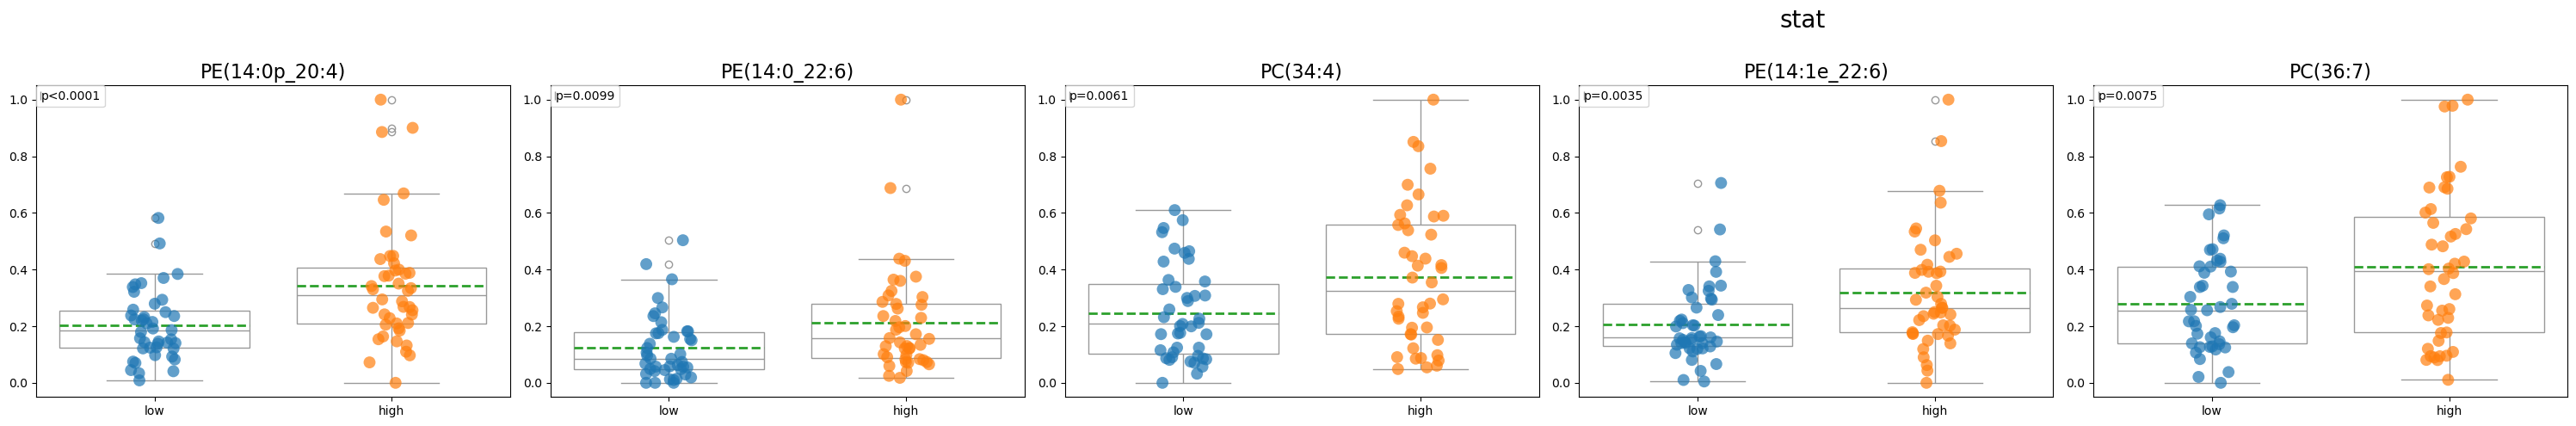

In [53]:
draw_box(using_df,sig_features[selection_method],class_label=class_label)